In [84]:
# DATASET
# https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html

# PANDAS
# https://queirozf.com/entries/pandas-dataframe-examples-column-operations

# PLOTTING
# https://seaborn.pydata.org/generated/seaborn.countplot.html
# http://seaborn.pydata.org/tutorial/categorical.html

# KNN 
# https://scikit-learn.org/stable/modules/neighbors.html
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
    
# TODO
# https://spacy.io/


In [85]:
from sklearn.datasets import fetch_20newsgroups
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import numpy as np
from sklearn import metrics
import spacy
from spacy.lang.en import English
from ipywidgets import IntProgress
from IPython.display import display



In [86]:
# set plotting parameters
sns.set_theme(style="darkgrid")
plt.rcParams["axes.labelsize"] = 20

<div>
  <h2>Import Data from Newsgroup Datasets</h2>    
</div>    

In [87]:
class NewsGroupImporter(object):
    categories = []
    subset = ''
    remove = []
    
    raw_data = None
    dataframe = None
    target_categories = []
    
    def __init__(self, categories=None):
        self.categories = categories
        self.subset = 'test'
        self.remove = ['footers', 'quotes'] 
        
        self.get_newsgroup_raw_data()
        self.create_data_frame()
        
    def get_newsgroup_raw_data(self):
        self.raw_data = fetch_20newsgroups(
            subset=self.subset, 
            categories=self.categories, 
            remove=self.remove
        )
        self.target_categories = self.raw_data['target_names']
        
    @staticmethod    
    def get_subject(text):
        subject = str()
        for line in text.split('\n'):
            if line.startswith('Subject:'):
                subject = line.replace('Subject:', '', 1).strip()
        return subject
        
    @staticmethod        
    def validate_line_start(line):
        bad_starts = [
            'From:',
            'Subject:',
            'Organization:',
            'Lines:',
            'Reply-To:',
            'NNTP-Posting-Host:',
            'Distribution:'
        ]

        for bad_start in bad_starts:
            if line.lower().startswith(bad_start.lower()):
               return False
        return True    
        
    def get_processed_text(self, text):
        lines = list()
    
        for line in text.split('\n'):
            if not self.validate_line_start(line):
               continue
            
            line = line.strip()
            if not line:
                continue
        
            lines.append(line)       
        return ' '.join(lines)
        
    def create_data_frame(self):
        item_keys = ['data', 'filenames', 'target']
        item_data = {key: self.raw_data[key] for key in item_keys}
            
        self.dataframe = pandas.DataFrame.from_dict(item_data)
        
        # cleanup: add filename column remove filenames column
        filenames = pandas.Series([filepath.split('/')[-1] for filepath in self.dataframe['filenames']])
        self.dataframe['filename'] = filenames
        self.dataframe.drop(columns=['filenames'], inplace=True)
     
        # add target_category column
        item_target_names = [self.target_categories[target] for target in self.dataframe['target']] 
        self.dataframe['target_category'] = pandas.Series(item_target_names)
        
        # add subject column
        item_subjects = [self.get_subject(text) for text in self.dataframe['data']]
        self.dataframe['subject'] = pandas.Series(item_subjects)
        
        # add text column
        item_processed_texts = [self.get_processed_text(text) for text in self.dataframe['data']]
        self.dataframe['text'] = pandas.Series(item_processed_texts)
        
        # cleanup: drop data column
        self.dataframe.drop(columns=['data'], inplace=True)        

    def show_target_categories_histogram(self, target_column='target_category'):
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(1, 1, 1)
        sns.countplot(data=self.dataframe, x=target_column, ax=ax)
    

In [88]:
categories = ['rec.autos', 'comp.graphics', 'sci.med']    
importer = NewsGroupImporter(categories=categories)

importer.dataframe

,target,filename,target_category,subject,text
0,2,59363,sci.med,Re: Is MSG sensitivity superstition?,"Heck, I seem to feel like that *every* time I ..."
1,1,103724,rec.autos,GTS Headlight Covers,I have a 90 Eagle Talon and I wanted a pair of...
2,2,59234,sci.med,Re: cholistasis(sp?)/fat-free diet/pregnancy!!,"For one week, she probably wants to see how yo..."
3,0,38914,comp.graphics,Re: GeoSphere Image,This image is copyrighted. Early in another ne...
4,2,59283,sci.med,HICN611 Medical News Part 1/4,------------- cut here ----------------- Volum...
...,...,...,...,...,...
1176,0,38834,comp.graphics,What is the difference between Raytracing and ...,"Hello, I've raytraced and rendered and the onl..."
1177,0,39001,comp.graphics,Re: SGI sales practices (Was: Crimson (Was: Ku...,"No, MIS folks have infinite budgets of death, ..."
1178,1,103717,rec.autos,Question about Integra Auto box,I'm new to this group and this may have been d...
1179,1,103690,rec.autos,Re: horizontally opposed/boxer engines (was: V...,and didn't you also say that it was easier to ...


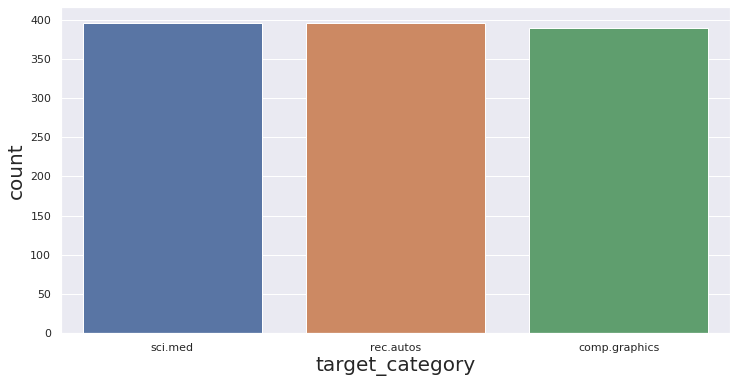

In [89]:
importer.show_target_categories_histogram()

<div>
  <h2>Vectorize Data</h2>    
</div>    

In [90]:
class VectorizerTool(object):
    texts = []
    vectorizer = None

    def __init__(self, texts):
        self.texts = texts
        self.vectorizer = self.get_fitted_vectorizer()
    
    def get_fitted_vectorizer(self):
        tfidf_vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_vectorizer.fit(self.texts)
        return tfidf_vectorizer
    
    def plot_vocabulary_info(self):
        names = self.vectorizer.get_feature_names_out() 
        vectorized_data = self.vectorizer.transform(self.texts)
    
        print('Vectorized Data Info: \n')
        print('Number of Elements:', vectorized_data.shape[0])
        print('Number of Features:', vectorized_data.shape[1])
        print('-----------------------------------------')
        
        summed_values = vectorized_data.sum(axis=0).tolist()[0]
        sorted_values = [value for value in zip(names, summed_values)]
        sorted_values = sorted(sorted_values, key=lambda x: -x[1])

        n_show = 20
        print(f'First {n_show} Sorted Summed Vecorizer Values: \n')
        for name, summed_value in sorted_values[:n_show]:
            print(f'"{name}" :', summed_value)
        print('-----------------------------------------')
    
        print('All Summed Vectorizer Values Plot: \n')
        all_sorted_values = [value[1] for value in sorted_values]
    
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(range(len(all_sorted_values)), all_sorted_values)
        ax.set_ylabel('Summed Vecorizer Values')    
        plt.show()        


In [91]:
class ClassificationTool(object):
    importer = None
    vectorizer = None
    
    def __init__(self, importer, vectorizer):
        self.vectorizer = vectorizer
        self.texts = importer.dataframe['text']
        self.targets = importer.dataframe['target']
        self.target_categories = importer.target_categories
        
            
    def get_nearest_neighbors_target_id(self, model_knn, text, num=5):
        vectorized_texts = self.vectorizer.transform([text])
    
        distances, indexes = model_knn.kneighbors(vectorized_texts, n_neighbors=num + 1)
    
        nearest_target_ids = list()
        for distance, index in zip(distances[0], indexes[0]):
            if distance == 0:
                continue
            nearest_target_ids.append(self.targets[index])
    
        if not nearest_target_ids:
            return -1
    
        counter = Counter(nearest_target_ids)
        return counter.most_common(1)[0][0]
        
    def plot_classification_report(self):
        vectorized_texts = self.vectorizer.transform(self.texts)
    
        model_knn = NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=1, n_jobs=-1)
        model_knn.fit(vectorized_texts)
        
        progress_bar = IntProgress(min=0, max=len(self.texts) - 1)
        display(progress_bar)

        predictions = list()
        for text in self.texts:
            progress_bar.value += 1
            
            predicted_target_id = self.get_nearest_neighbors_target_id(model_knn, text)
            predictions.append(predicted_target_id)            
        
        print(metrics.classification_report(
            self.targets,
            predictions,
            target_names=self.target_categories
        )) 
        


## Run Default (Tf-Idf) Vectorizer

In [92]:
vectorizer_tool = VectorizerTool(texts=importer.dataframe['text'])

classification_tool = ClassificationTool(vectorizer=vectorizer_tool.vectorizer, importer=importer)
classification_tool.plot_classification_report()

IntProgress(value=0, max=1180)

               precision    recall  f1-score   support

comp.graphics       0.85      0.92      0.88       389
    rec.autos       0.94      0.79      0.86       396
      sci.med       0.81      0.87      0.84       396

     accuracy                           0.86      1181
    macro avg       0.87      0.86      0.86      1181
 weighted avg       0.87      0.86      0.86      1181



## Run Count Vectorizer

In [93]:
class CountVectorizerTool(VectorizerTool):
    
    def get_fitted_vectorizer(self):
        count_vectorizer = CountVectorizer(stop_words='english')
        count_vectorizer.fit(self.texts)
        return count_vectorizer
    
vectorizer_tool = CountVectorizerTool(texts=importer.dataframe['text'])
classification_tool = ClassificationTool(vectorizer=vectorizer_tool.vectorizer, importer=importer)

classification_tool.plot_classification_report()

IntProgress(value=0, max=1180)

               precision    recall  f1-score   support

comp.graphics       0.82      0.88      0.85       389
    rec.autos       0.91      0.80      0.85       396
      sci.med       0.79      0.84      0.81       396

     accuracy                           0.84      1181
    macro avg       0.84      0.84      0.84      1181
 weighted avg       0.84      0.84      0.84      1181



Vectorized Data Info: 

Number of Elements: 1181
Number of Features: 19950
-----------------------------------------
First 20 Sorted Summed Vecorizer Values: 

"image" : 669
"edu" : 579
"jpeg" : 532
"graphics" : 460
"like" : 448
"know" : 375
"file" : 374
"use" : 373
"don" : 363
"car" : 340
"just" : 331
"available" : 330
"does" : 321
"images" : 303
"information" : 292
"data" : 287
"good" : 280
"software" : 279
"new" : 278
"bit" : 272
-----------------------------------------
All Summed Vectorizer Values Plot: 



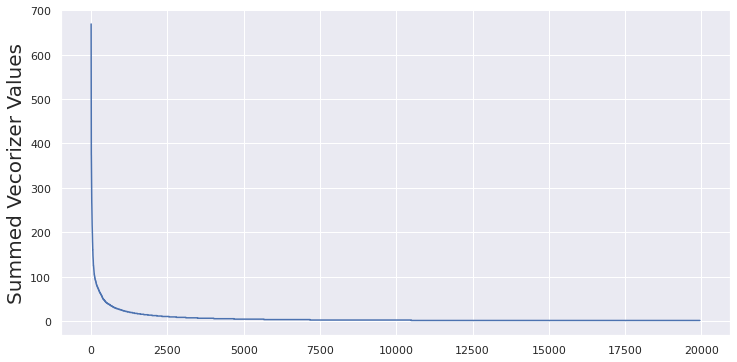

In [94]:
vectorizer_tool.plot_vocabulary_info()